In [2]:
# %matplotlib nbagg
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import pickle
from datetime import datetime

sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import coloredlogs, logging
logger = logging.getLogger(__name__)
coloredlogs.install(level='CRITICAL', logger=logger)

import pymongo
from pymongo import MongoClient
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
import scipy
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime, UpdateDist, display_two_images
from controllers.learner.img2vec import NNFeatures
import controllers.learner.datasets as ds
from controllers.tests.hue_lv2 import HueLv2

mongo = MongoClient('localhost', 20202).hai
from flask import Flask
app = Flask(__name__)
app.config.from_pyfile(filename="application.cfg")

True

In [17]:
hue_lv2 = HueLv2('koki', debug=True)

  0%|          | 0/1200 [00:00<?, ?it/s]

start vectorizing


100%|██████████| 1200/1200 [04:11<00:00,  4.70it/s]

In [18]:
len(hue_lv2.X)

1200

In [19]:
len(hue_lv2.y)

1200

In [20]:
hue_lv2.operating_instructions

[{'on': False},
 {'bri': 254, 'hue': 14910, 'on': True, 'sat': 144},
 {'bri': 254, 'hue': 2049, 'on': True, 'sat': 0}]

<IPython.core.display.Javascript object>


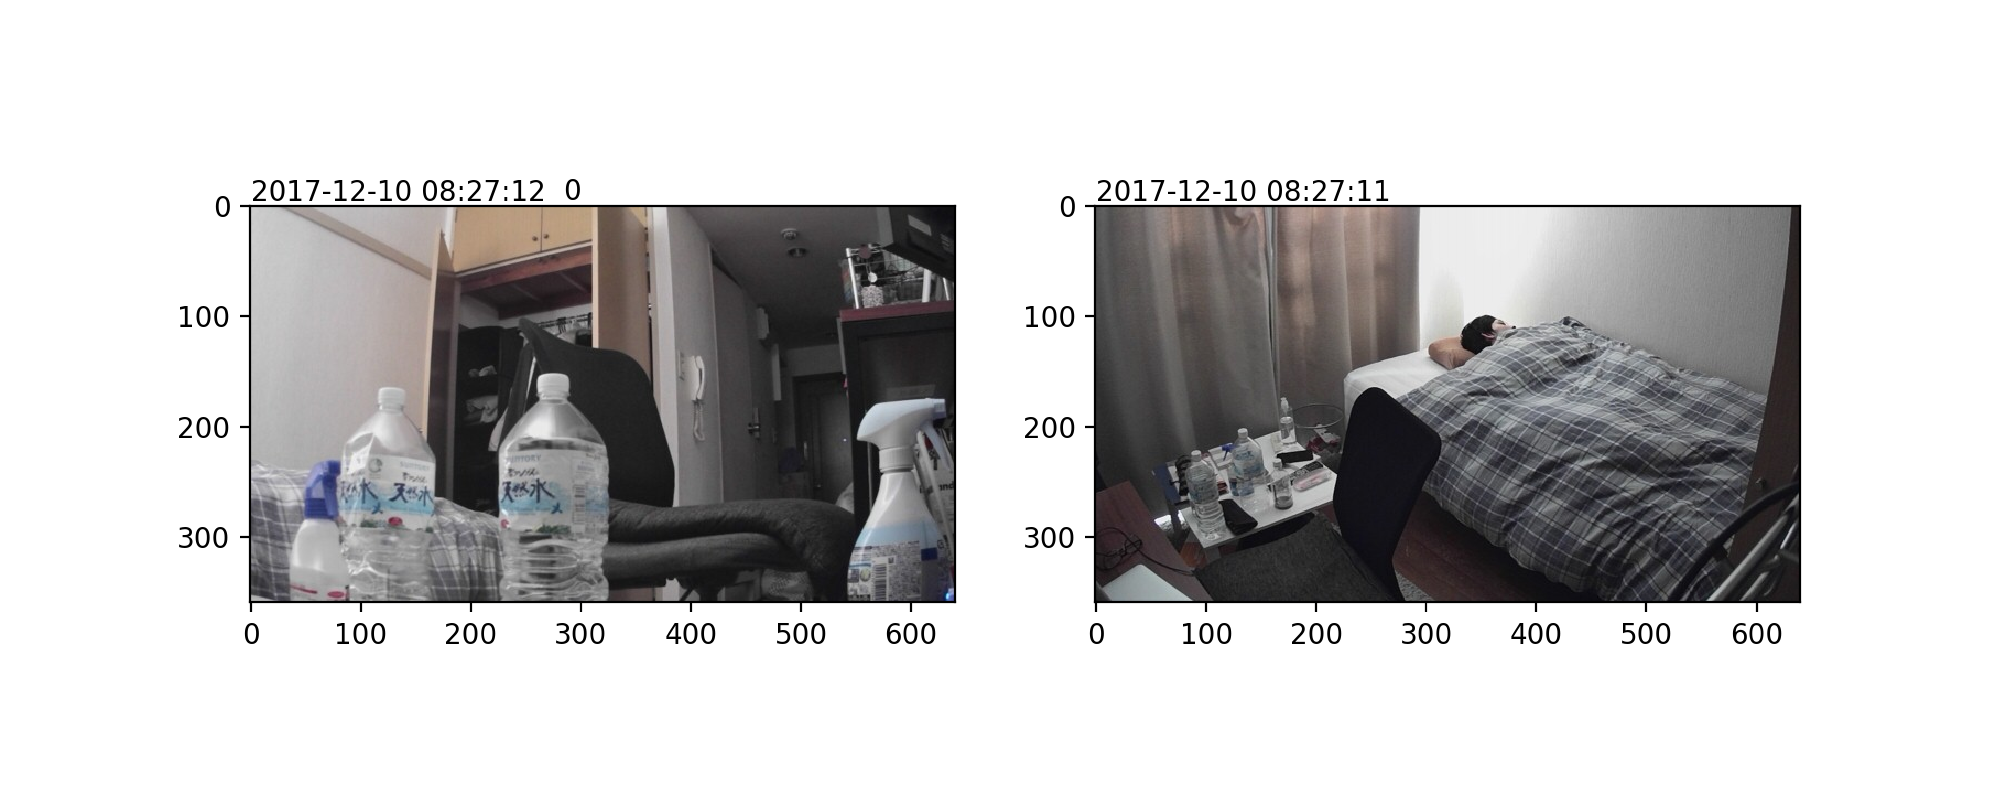

In [22]:
%matplotlib nbagg
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, hue_lv2.X, info=hue_lv2.y)
ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
ani.save('1210-08.mp4', writer="ffmpeg")
# fig.show()

In [24]:
pickle.dump(hue_lv2.X, open('X-08.pkl', 'wb'))
pickle.dump(hue_lv2.y, open('y-08.pkl', 'wb'))

In [26]:
X = pickle.load(open('X-08.pkl', 'rb'))
y = pickle.load(open('y-08.pkl', 'rb'))

In [29]:
y[0]

0

In [30]:
import numpy as np
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation

clf = linear_model.SGDClassifier(loss='log')
pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=50)),
            ("clf", clf)
    ])

# pipe.fit(hue_lv2.learner.X, hue_lv2.learner.y)

cross_validation.cross_val_score(pipe, hue_lv2.learner.X, hue_lv2.learner.y, cv=5)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type

array([ 0.97916667,  0.97083333,  1.        ,  1.        ,  0.93333333])

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(hue_lv2.learner.X, hue_lv2.learner.y, train_size=0.6, random_state=1)
pipe.fit(X_train, y_train)
pipe.predict_proba(X_val)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


array([[  0.00000000e+000,   1.00000000e+000,   1.04855703e-299],
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       ..., 
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000]])

<IPython.core.display.Javascript object>


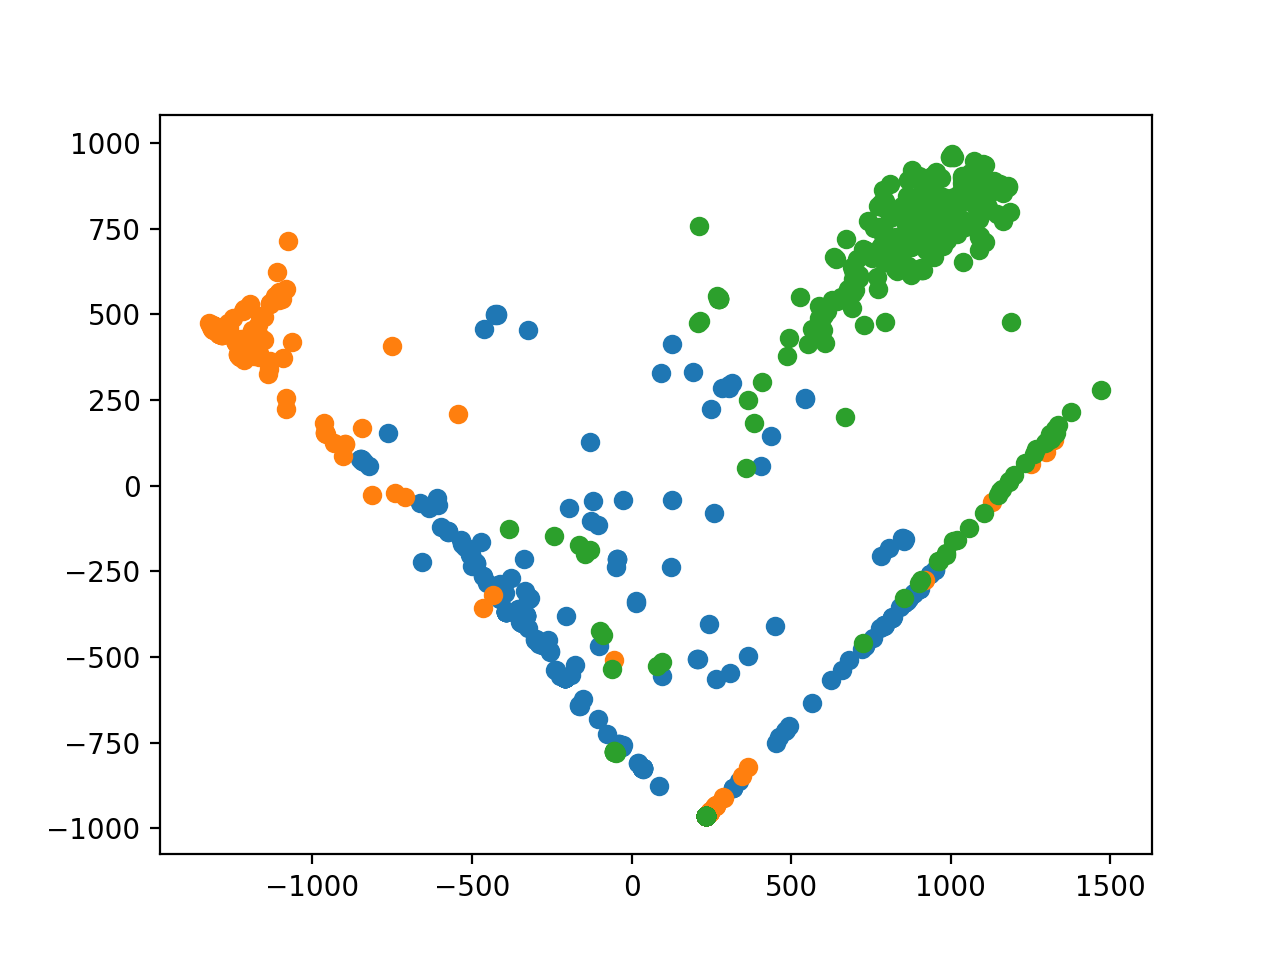

In [39]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(hue_lv2.learner.X)

for i in [0, 1, 2]:
    X = X_2d[np.where(hue_lv2.learner.y == i)]
    plt.scatter(X[:, 0], X[:, 1])
    
plt.show()

In [36]:
X0 = hue_lv2.learner.X[np.where(hue_lv2.learner.y == 0)]

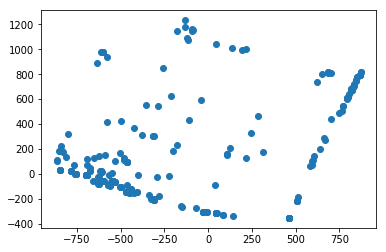

In [40]:
%matplotlib inline
pca = PCA(n_components=2)
X0_2d = pca.fit_transform(X0)
plt.scatter(X0_2d[:, 0], X0_2d[:, 1])
plt.show()

In [42]:
X0.shape

(400, 1132)

In [45]:
np.average(X0[:3], axis=0)

array([ 0.49009814,  1.55087427,  0.91806956, ...,  0.        ,
        0.        ,  0.        ])

In [63]:
def get_mean_vector(X, length=3):
    result = []
    for i in range(len(X0)-length):
        result.append(np.average(X0[i:i+length], axis=0))
    return np.array(result)

In [64]:
mean_X0 = get_mean_vector(X0, length=5)

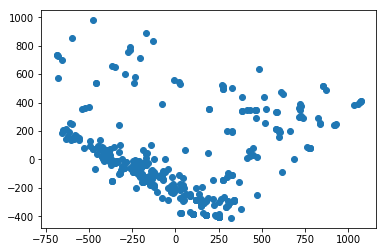

In [65]:
pca = PCA(n_components=2)
X0_2d = pca.fit_transform(mean_X0)
plt.scatter(X0_2d[:, 0], X0_2d[:, 1])
plt.show()

In [66]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X0_2d)

In [82]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [77]:
np.array(hue_lv2.X)[np.where(kmeans.labels_ == 1)][0]

{'_id': ObjectId('5a2c6d7e1d41c801931306c8'),
 'cam_id': 'webcam0',
 'detections': [{'box': [298, 3, 564, 334],
   'confidence': 0.9984448552131653,
   'label': 'person',
   'list_index': 0},
  {'box': [166, 173, 180, 220],
   'confidence': 0.9271419644355774,
   'label': 'bottle',
   'list_index': 1},
  {'box': [178, 181, 226, 243],
   'confidence': 0.9208264350891113,
   'label': 'cup',
   'list_index': 2},
  {'box': [85, 222, 117, 297],
   'confidence': 0.9085404872894287,
   'label': 'bottle',
   'list_index': 3},
  {'box': [124, 203, 151, 251],
   'confidence': 0.9031305313110352,
   'label': 'bottle',
   'list_index': 4},
  {'box': [158, 226, 180, 279],
   'confidence': 0.8884848952293396,
   'label': 'bottle',
   'list_index': 5},
  {'box': [298, 77, 605, 360],
   'confidence': 0.6814113259315491,
   'label': 'bed',
   'list_index': 6},
  {'box': [44, 192, 230, 340],
   'confidence': 0.5175303220748901,
   'label': 'dining table',
   'list_index': 7}],
 'diff_filename': '8829611

<IPython.core.display.Javascript object>


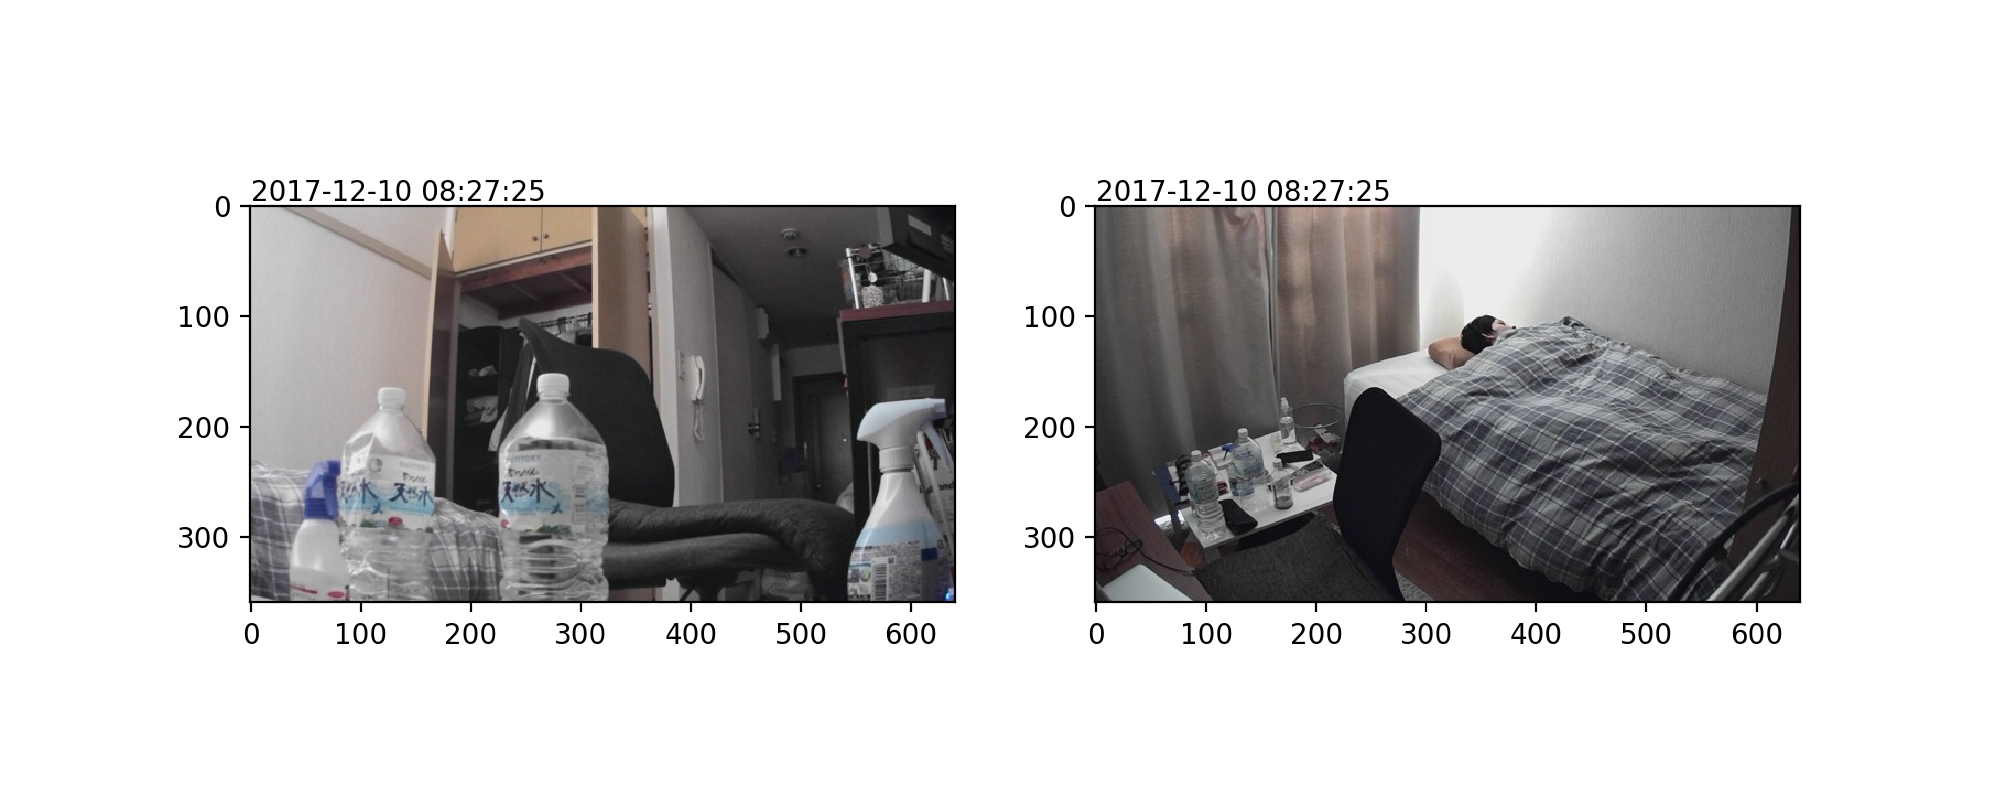

In [81]:
%matplotlib nbagg
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, np.array(hue_lv2.X)[np.where(kmeans.labels_ == 0)])
ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
# ani.save('1210-08.mp4', writer="ffmpeg")
fig.show()

In [83]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

n_samples = 125
n_outliers = 25
n_features = 2

In [84]:
robust_cov = MinCovDet().fit(X0)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [85]:
robust_cov

MinCovDet(assume_centered=False, random_state=None, store_precision=True,
     support_fraction=None)

In [ ]:
fig = plt.figure()
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                               color='red', label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

In [91]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from scipy import stats

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
outliers_fraction = 0.05
clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma='auto') 
clf.fit(X0)
y_pred = clf.decision_function(X0).ravel()

In [107]:
y_pred

array([ -1.50204939e+00,  -1.50204939e+00,  -1.50203362e+00,
        -4.29295302e-01,   3.57171863e-04,  -1.50204939e+00,
        -1.00868433e-04,  -1.80592059e-04,  -6.80365644e-05,
        -2.08370344e-01,   1.59596884e-04,   3.59807016e-04,
        -1.06288080e-02,  -1.50204939e+00,  -1.50204939e+00,
        -4.75932371e-01,  -1.50204939e+00,  -8.31213076e-02,
         1.82353647e-05,  -1.50204939e+00,  -1.50204939e+00,
         2.86391921e-02,   5.87176787e-02,   4.21615096e-05,
         2.52198334e-02,  -1.50204939e+00,  -6.70751058e-02,
         1.92805059e-02,  -2.40163747e-01,   1.19240536e-02,
         2.37046625e-02,  -1.50204939e+00,   7.27345208e-03,
        -4.10519581e-04,   2.82105415e-02,   2.99937420e-02,
         2.35286112e-02,  -2.55614709e-04,   1.32119599e-05,
         3.74488054e-02,   9.33243596e-03,   1.04675010e-02,
         2.35358928e-04,   2.46901437e-04,   3.42681073e-04,
         1.70903870e-05,   3.06199498e-04,   2.81267365e-04,
         6.08632305e-05,

In [125]:
index = np.where(y_pred <  -0.1)

<IPython.core.display.Javascript object>


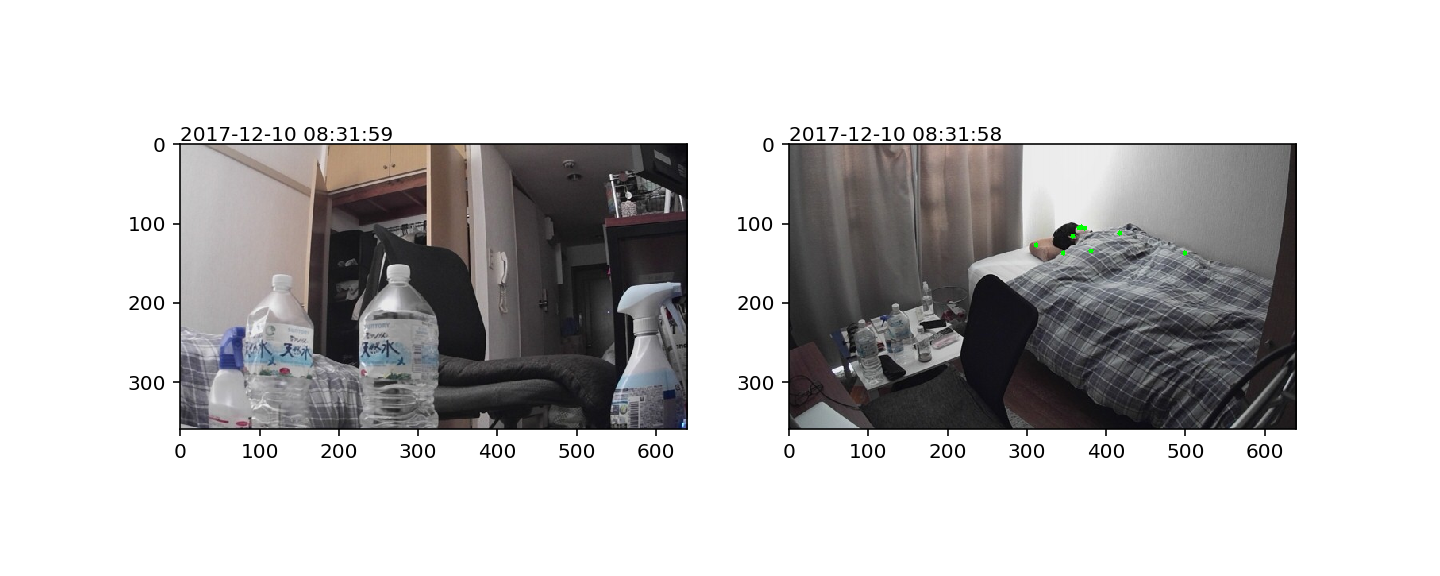

In [126]:
%matplotlib nbagg
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, np.array(hue_lv2.X)[index], pose=True)
ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
# ani.save('1210-08.mp4', writer="ffmpeg")
fig.show()

In [127]:
index = np.where(y_pred >  -0.1)

<IPython.core.display.Javascript object>


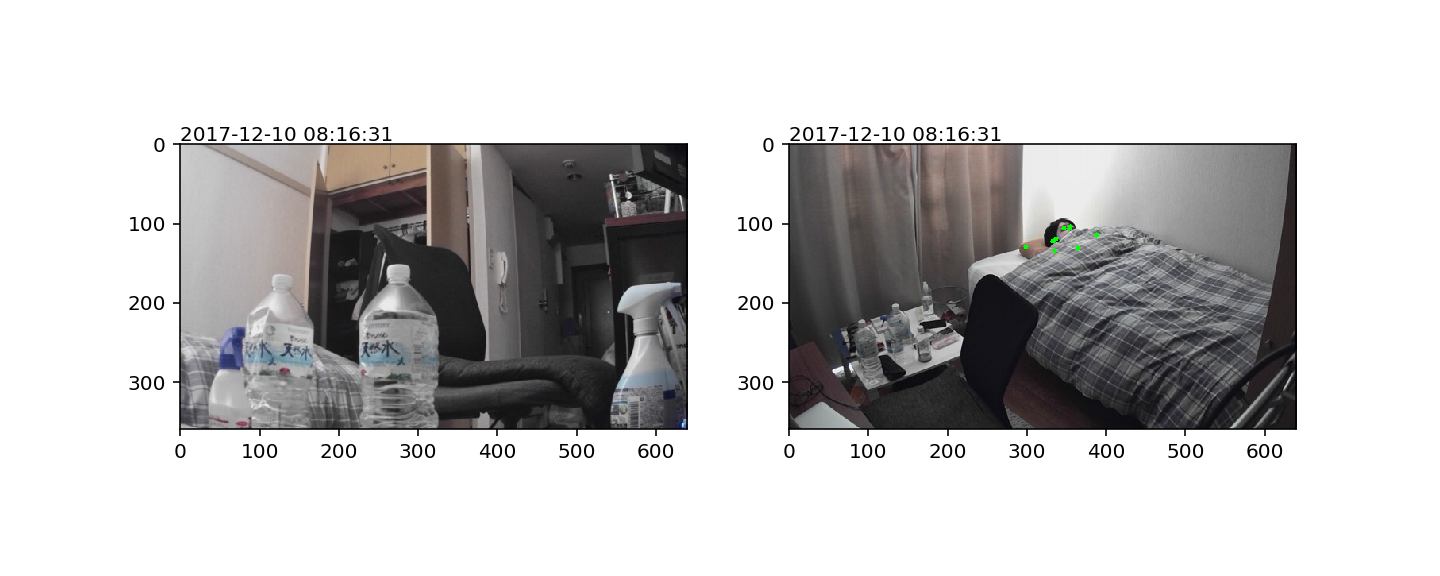

In [128]:
%matplotlib nbagg
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, np.array(hue_lv2.X)[index], pose=True)
ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
# ani.save('1210-08.mp4', writer="ffmpeg")
fig.show()